In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *

In [ ]:
# Modelos
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor,
                              RandomForestClassifier, GradientBoostingClassifier)
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from xgboost import XGBRegressor, XGBClassifier

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# CONFIGURACIÓN INICIAL
# =============================================================================

ARCHIVO_DATOS = 'df_cluster_19.csv'
TEST_SIZE = 0.2
UMBRAL_LLUVIA = 0.2  # mm
RANDOM_STATE = 42

In [ ]:
print("MÓDULO 3: PREDICCIÓN DE PRECIPITACIÓN POR MICROCLIMA")
print("=" * 80)

MÓDULO 3: PREDICCIÓN DE PRECIPITACIÓN POR MICROCLIMA


In [ ]:
# Cargar datos
df = pd.read_csv('df_cluster_19.csv' ,parse_dates=['datetime'], index_col='datetime')
print(f"✓ Datos cargados: {df.shape}")

✓ Datos cargados: (54406, 7)


In [ ]:
# Crear features temporales y lags
def crear_features_completas(df):
    df_feat = df.copy()

    # Temporales
    df_feat['hora'] = df_feat.index.hour
    df_feat['dia_semana'] = df_feat.index.dayofweek
    df_feat['mes'] = df_feat.index.month
    df_feat['dia_año'] = df_feat.index.dayofyear

    # Cíclicas
    df_feat['hora_sin'] = np.sin(2 * np.pi * df_feat['hora'] / 24)
    df_feat['hora_cos'] = np.cos(2 * np.pi * df_feat['hora'] / 24)
    df_feat['mes_sin'] = np.sin(2 * np.pi * df_feat['mes'] / 12)
    df_feat['mes_cos'] = np.cos(2 * np.pi * df_feat['mes'] / 12)

    # Variables meteorológicas
    vars_meteo = ['temperatura', 'humedad', 'presion', 'velocidad', 'radiacion']

    # Lags
    for var in vars_meteo + ['precipitacion_real']:
        if var in df_feat.columns:
            for lag in [1, 3, 6, 12, 24]:
                df_feat[f'{var}_lag{lag}'] = df_feat[var].shift(lag)

    # Rolling
    for var in vars_meteo:
        if var in df_feat.columns:
            for w in [3, 6, 12]:
                df_feat[f'{var}_roll{w}'] = df_feat[var].rolling(w).mean()

    # Diferencias
    for var in vars_meteo:
        if var in df_feat.columns:
            df_feat[f'{var}_diff'] = df_feat[var].diff()

    return df_feat

In [ ]:
df_features = crear_features_completas(df)
df_features = df_features.dropna()

In [ ]:
# Crear targets
df_features['target_precipitacion'] = df_features['precipitacion_real'].shift(-1)
df_features['target_lluvia_binaria'] = (df_features['target_precipitacion'] > UMBRAL_LLUVIA).astype(int)
df_features = df_features.dropna(subset=['target_precipitacion'])

print(f"✓ Features creadas: {df_features.shape}")
print(f"✓ Distribución target: {df_features['target_lluvia_binaria'].value_counts().to_dict()}")


✓ Features creadas: (54381, 67)
✓ Distribución target: {0: 53657, 1: 724}


In [ ]:
# PASO 2: SELECCIÓN DE FEATURES Y DIVISIÓN DE DATOS
# =============================================================================

print("\n[2/6] Seleccionando features y dividiendo datos...")
# Seleccionar features
excluir = ['precipitacion_real', 'target_precipitacion', 'target_lluvia_binaria',
           'fecha', 'hora', 'direccion_rosa', 'observaciones',
           'puerta_Abierta', 'bateria_Baja', 'solar_energia', 'sensor_Activo']

feature_cols = [col for col in df_features.columns
                if col not in excluir and df_features[col].dtype in ['float64', 'int64']]

print(f"✓ Features seleccionadas: {len(feature_cols)}")

# División temporal
n = len(df_features)
split_idx = int(n * (1 - TEST_SIZE))

train_df = df_features.iloc[:split_idx]
test_df = df_features.iloc[split_idx:]

X_train = train_df[feature_cols]
y_train_reg = train_df['target_precipitacion']
y_train_clf = train_df['target_lluvia_binaria']

X_test = test_df[feature_cols]
y_test_reg = test_df['target_precipitacion']
y_test_clf = test_df['target_lluvia_binaria']

print(f"✓ Train: {len(train_df)} | Test: {len(test_df)}")
# Escalar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

print("✓ Features escaladas")


[2/6] Seleccionando features y dividiendo datos...
✓ Features seleccionadas: 60
✓ Train: 43504 | Test: 10876
✓ Features escaladas


In [ ]:
print("\n[3/6] Entrenando modelos de REGRESIÓN (cantidad de lluvia)...")

modelos_reg = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=RANDOM_STATE),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15,
                                          random_state=RANDOM_STATE, n_jobs=-1),
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=5,
                           learning_rate=0.1, random_state=RANDOM_STATE)
}

resultados_reg = {}


[3/6] Entrenando modelos de REGRESIÓN (cantidad de lluvia)...


In [ ]:
for nombre, modelo in modelos_reg.items():
    modelo.fit(X_train_scaled, y_train_reg)
    y_pred = modelo.predict(X_test_scaled)

    rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred))
    mae = mean_absolute_error(y_test_reg, y_pred)
    r2 = r2_score(y_test_reg, y_pred)

    resultados_reg[nombre] = {
        'modelo': modelo,
        'predicciones': y_pred,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

    print(f"  {nombre:20s} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

  Linear               | RMSE: 0.2089 | MAE: 0.0479 | R²: 0.5192
  Ridge                | RMSE: 0.2088 | MAE: 0.0477 | R²: 0.5194
  Decision Tree        | RMSE: 0.4376 | MAE: 0.0493 | R²: -1.1113
  Random Forest        | RMSE: 0.2743 | MAE: 0.0420 | R²: 0.1707
  XGBoost              | RMSE: 0.3510 | MAE: 0.0425 | R²: -0.3578


In [ ]:
# Mejor modelo
mejor_reg = min(resultados_reg.keys(), key=lambda x: resultados_reg[x]['rmse'])
print(f"\n✓ Mejor modelo de regresión: {mejor_reg}")


✓ Mejor modelo de regresión: Ridge


In [ ]:
print("\n[4/6] Entrenando modelos de CLASIFICACIÓN (¿va a llover?)...")

modelos_clf = {
    'Logistic': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=15,
                                           random_state=RANDOM_STATE, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=5,
                            learning_rate=0.1, random_state=RANDOM_STATE,
                            eval_metric='logloss')
}



[4/6] Entrenando modelos de CLASIFICACIÓN (¿va a llover?)...


In [ ]:
resultados_clf = {}
for nombre, modelo in modelos_clf.items():
    modelo.fit(X_train_scaled, y_train_clf)
    y_pred = modelo.predict(X_test_scaled)
    y_proba = modelo.predict_proba(X_test_scaled)[:, 1]

    acc = accuracy_score(y_test_clf, y_pred)
    prec = precision_score(y_test_clf, y_pred, zero_division=0)
    rec = recall_score(y_test_clf, y_pred, zero_division=0)
    f1 = f1_score(y_test_clf, y_pred, zero_division=0)
    auc = roc_auc_score(y_test_clf, y_proba) if len(np.unique(y_test_clf)) > 1 else 0

    resultados_clf[nombre] = {
        'modelo': modelo,
        'predicciones': y_pred,
        'probabilidades': y_proba,
        'acc': acc,
        'f1': f1,
        'auc': auc
    }

    print(f"  {nombre:20s} | Acc: {acc:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

mejor_clf = max(resultados_clf.keys(), key=lambda x: resultados_clf[x]['f1'])
print(f"\n✓ Mejor modelo de clasificación: {mejor_clf}")

  Logistic             | Acc: 0.9760 | F1: 0.1869 | AUC: 0.9096
  Decision Tree        | Acc: 0.9774 | F1: 0.5176 | AUC: 0.7327
  Random Forest        | Acc: 0.9756 | F1: 0.2363 | AUC: 0.9576
  XGBoost              | Acc: 0.9771 | F1: 0.3759 | AUC: 0.9659

✓ Mejor modelo de clasificación: Decision Tree



[5/6] Generando visualizaciones comparativas...


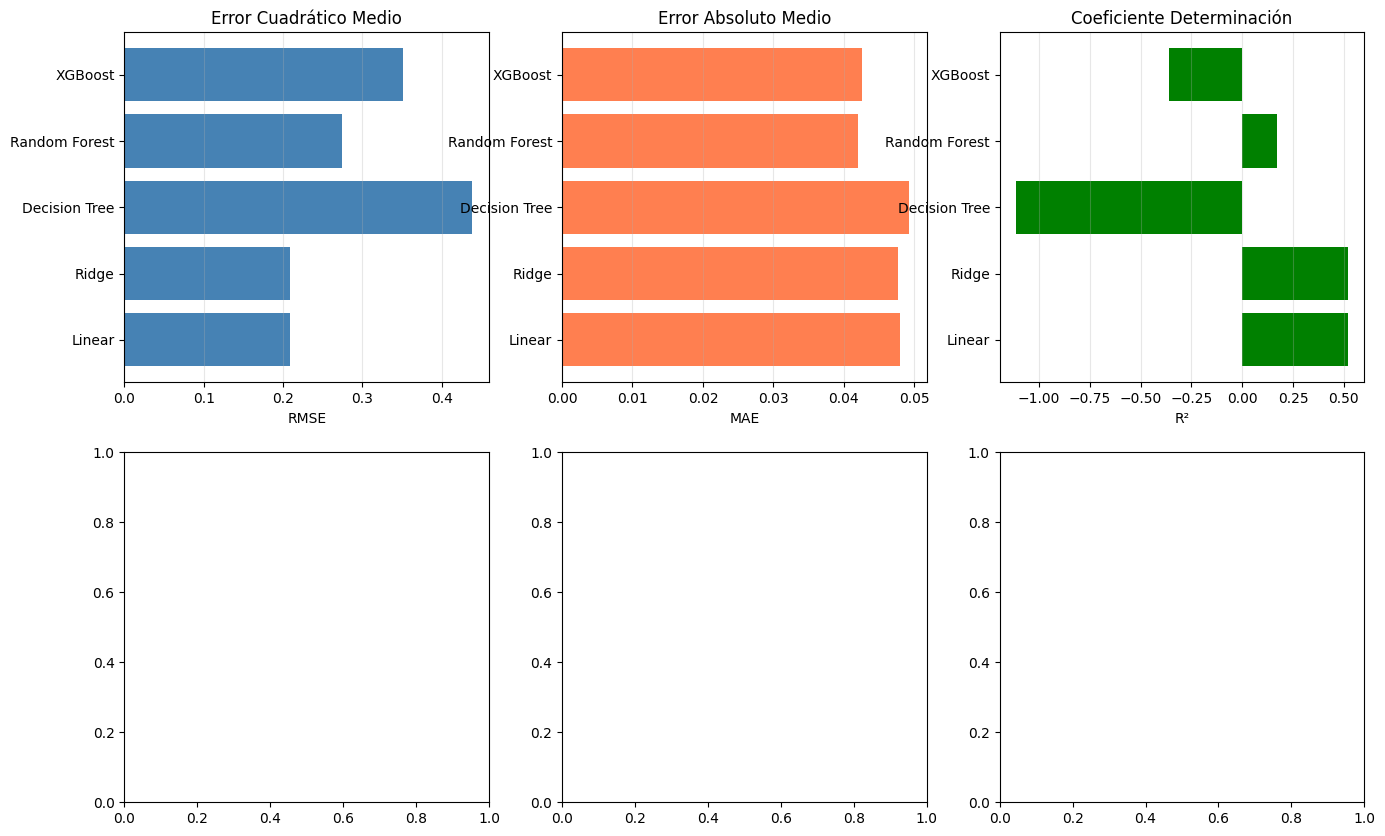

In [ ]:
# PASO 5: VISUALIZACIÓN COMPARATIVA
# =============================================================================

print("\n[5/6] Generando visualizaciones comparativas...")

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Comparación modelos regresión
modelos = list(resultados_reg.keys())
rmse_vals = [resultados_reg[m]['rmse'] for m in modelos]
mae_vals = [resultados_reg[m]['mae'] for m in modelos]
r2_vals = [resultados_reg[m]['r2'] for m in modelos]

axes[0, 0].barh(modelos, rmse_vals, color='steelblue')
axes[0, 0].set_xlabel('RMSE')
axes[0, 0].set_title('Error Cuadrático Medio')
axes[0, 0].grid(axis='x', alpha=0.3)

axes[0, 1].barh(modelos, mae_vals, color='coral')
axes[0, 1].set_xlabel('MAE')
axes[0, 1].set_title('Error Absoluto Medio')
axes[0, 1].grid(axis='x', alpha=0.3)

axes[0, 2].barh(modelos, r2_vals, color='green')
axes[0, 2].set_xlabel('R²')
axes[0, 2].set_title('Coeficiente Determinación')
axes[0, 2].grid(axis='x', alpha=0.3)

In [ ]:
# Comparación modelos clasificación
modelos_c = list(resultados_clf.keys())
acc_vals = [resultados_clf[m]['acc'] for m in modelos_c]
f1_vals = [resultados_clf[m]['f1'] for m in modelos_c]
auc_vals = [resultados_clf[m]['auc'] for m in modelos_c]

axes[1, 0].barh(modelos_c, acc_vals, color='steelblue')
axes[1, 0].set_xlabel('Accuracy')
axes[1, 0].set_title('Exactitud')
axes[1, 0].grid(axis='x', alpha=0.3)

axes[1, 1].barh(modelos_c, f1_vals, color='coral')
axes[1, 1].set_xlabel('F1-Score')
axes[1, 1].set_title('F1-Score')
axes[1, 1].grid(axis='x', alpha=0.3)

axes[1, 2].barh(modelos_c, auc_vals, color='green')
axes[1, 2].set_xlabel('ROC-AUC')
axes[1, 2].set_title('AUC')
axes[1, 2].grid(axis='x', alpha=0.3)

plt.suptitle('Comparación de Modelos: Regresión (arriba) y Clasificación (abajo)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

In [ ]:
# PASO 6: PREDICCIÓN POR MICROCLIMA
# =============================================================================

print("\n[6/6] Generando predicciones por microclima...")

# Verificar si existe columna Cluster
if 'Cluster' in df_features.columns:
    # Predecir en todo el dataset
    X_all_scaled = scaler.transform(df_features[feature_cols])

    modelo_reg_final = resultados_reg[mejor_reg]['modelo']
    modelo_clf_final = resultados_clf[mejor_clf]['modelo']

    pred_cantidad = modelo_reg_final.predict(X_all_scaled)
    pred_lluvia = modelo_clf_final.predict(X_all_scaled)
    pred_proba = modelo_clf_final.predict_proba(X_all_scaled)[:, 1]

    df_features['pred_cantidad_mm'] = pred_cantidad
    df_features['pred_va_llover'] = pred_lluvia
    df_features['prob_lluvia'] = pred_proba


[6/6] Generando predicciones por microclima...


In [ ]:
# Análisis por microclima
print("\n" + "=" * 80)
print("ANÁLISIS POR MICROCLIMA")
print("=" * 80)

# Verificar si existe columna Cluster antes de proceder con el análisis
if 'Cluster' in df_features.columns:
    for cluster in sorted(df_features['Cluster'].unique()):
        mask = df_features['Cluster'] == cluster
        datos = df_features[mask]

        prec_real_mean = datos['precipitacion_real'].mean()
        prec_pred_mean = datos['pred_cantidad_mm'].mean()
        freq_real = (datos['precipitacion_real'] > UMBRAL_LLUVIA).mean() * 100
        prob_mean = datos['prob_lluvia'].mean()

        print(f"\nMICROCLIMA {cluster} ({len(datos)} obs):")
        print(f"  Precip. real:    {prec_real_mean:.3f} mm")
        print(f"  Precip. predicha: {prec_pred_mean:.3f} mm")
        print(f"  Freq. lluvia:     {freq_real:.1f}%")
        print(f"  Prob. media:      {prob_mean:.2%}")
else:
    print("\n⚠ No se encontró columna 'Cluster'. Ejecuta Módulo 2 primero para realizar el análisis por microclima.")


ANÁLISIS POR MICROCLIMA

MICROCLIMA 0 (36832 obs):
  Precip. real:    0.037 mm
  Precip. predicha: 0.034 mm
  Freq. lluvia:     1.9%
  Prob. media:      1.76%

MICROCLIMA 1 (17548 obs):
  Precip. real:    0.001 mm
  Precip. predicha: 0.008 mm
  Freq. lluvia:     0.2%
  Prob. media:      0.25%


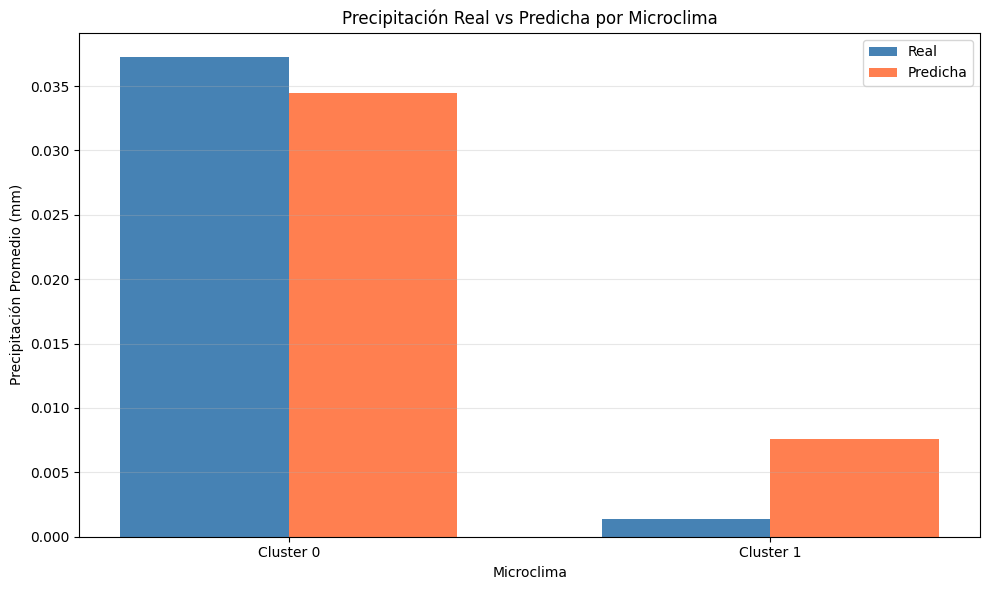


✓ Predicciones por microclima completadas


In [ ]:
# Visualización por microclima
if 'Cluster' in df_features.columns:
    clusters = sorted(df_features['Cluster'].unique())
    data_plot = []
    for c in clusters:
        mask = df_features['Cluster'] == c
        real = df_features.loc[mask, 'precipitacion_real'].mean()
        pred = df_features.loc[mask, 'pred_cantidad_mm'].mean()
        data_plot.append({'Cluster': c, 'Real': real, 'Predicha': pred})

    df_plot = pd.DataFrame(data_plot)

    plt.figure(figsize=(10, 6))
    x = np.arange(len(df_plot))
    width = 0.35

    plt.bar(x - width/2, df_plot['Real'], width, label='Real', color='steelblue')
    plt.bar(x + width/2, df_plot['Predicha'], width, label='Predicha', color='coral')
    plt.xlabel('Microclima')
    plt.ylabel('Precipitación Promedio (mm)')
    plt.title('Precipitación Real vs Predicha por Microclima')
    plt.xticks(x, [f'Cluster {c}' for c in df_plot['Cluster']])
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\n✓ Predicciones por microclima completadas")
else:
    print("\n⚠ No se encontró columna 'Cluster'. Ejecuta Módulo 2 primero.")

In [ ]:
# df_features[df_features['Cluster'] == 1]['precipitacion_real'].describe()

,precipitacion_real
count,17548.000000
mean,0.001411
std,0.032566
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,2.384640


In [ ]:
# df_features[df_features['Cluster'] == 0]['precipitacion_real'].describe()

,precipitacion_real
count,36832.000000
mean,0.037271
std,0.717226
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,45.400000


In [ ]:
# df_features[df_features['Cluster'] == 1]['precipitacion_real'].describe()

Text(0.5, 1.0, 'Distribución en Cluster 1')

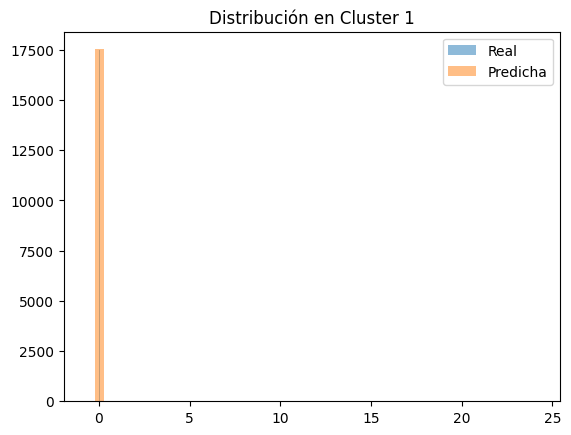

In [ ]:
# import matplotlib.pyplot as plt
# plt.hist(df_features[df_features['Cluster'] == 1]['precipitacion_real'], bins=50, alpha=0.5, label='Real')
# plt.hist(df_features[df_features['Cluster'] == 1]['pred_cantidad_mm'], bins=50, alpha=0.5, label='Predicha')
# plt.legend(); plt.title("Distribución en Cluster 1")

In [ ]:
# RESUMEN FINAL
# =============================================================================

print("\n" + "=" * 80)
print("RESUMEN FINAL")
print("=" * 80)
print(f"\n✓ Mejor modelo de regresión:     {mejor_reg}")
print(f"  - RMSE: {resultados_reg[mejor_reg]['rmse']:.4f}")
print(f"  - MAE:  {resultados_reg[mejor_reg]['mae']:.4f}")
print(f"  - R²:   {resultados_reg[mejor_reg]['r2']:.4f}")

print(f"\n✓ Mejor modelo de clasificación: {mejor_clf}")
print(f"  - Accuracy: {resultados_clf[mejor_clf]['acc']:.4f}")
print(f"  - F1-Score: {resultados_clf[mejor_clf]['f1']:.4f}")
print(f"  - ROC-AUC:  {resultados_clf[mejor_clf]['auc']:.4f}")



RESUMEN FINAL

✓ Mejor modelo de regresión:     Ridge
  - RMSE: 0.2088
  - MAE:  0.0477
  - R²:   0.5194

✓ Mejor modelo de clasificación: Decision Tree
  - Accuracy: 0.9774
  - F1-Score: 0.5176
  - ROC-AUC:  0.7327


In [ ]:
!python codigo_estadisticas_reales.py

python3: can't open file '/content/codigo_estadisticas_reales.py': [Errno 2] No such file or directory


In [ ]:
%%writefile codigo_estadisticas_reales.py
import pandas as pd
import numpy as np

def calculate_descriptive_stats(df, columns):
    stats = {}
    for col in columns:
        if col in df.columns:
            series = df[col].dropna()  # Eliminar NaN para cálculos correctos
            q1 = series.quantile(0.25)
            q3 = series.quantile(0.75)
            iqr = q3 - q1

            stats[col] = {
                'Media': series.mean(),
                'Mediana': series.median(),
                'Std': series.std(),
                'Q1': q1,
                'Q3': q3,
                'IQR': iqr,
                'Skewness': series.skew(),
                'Kurtosis': series.kurtosis()
            }
        else:
            stats[col] = f"Columna '{col}' no encontrada"
    return stats

if __name__ == "__main__":
    file_path = 'df_cluster_19.csv'

    print("=" * 80)
    print("GENERANDO ESTADÍSTICAS PARA EL INFORME")
    print("=" * 80)

    try:
        df = pd.read_csv(file_path)
        print(f"\n✓ Archivo cargado: {file_path}")
        print(f"✓ Filas: {len(df):,} | Columnas: {df.shape[1]}")
    except FileNotFoundError:
        print(f"❌ Error: El archivo '{file_path}' no se encontró.")
        exit()

    target_columns = ['temperatura', 'humedad', 'presion', 'velocidad',
                     'precipitacion_real', 'radiacion']

    print("\n" + "=" * 80)
    print("ANEXO A: ESTADÍSTICAS DETALLADAS POR VARIABLE")
    print("=" * 80)

    stats_results = calculate_descriptive_stats(df, target_columns)

    # Mostrar en formato de tabla
    print("\nFormato para visualización:")
    print("-" * 80)
    for col, data in stats_results.items():
        if not isinstance(data, str):
            print(f"\n📊 {col.upper()}:")
            for stat_name, stat_value in data.items():
                print(f"  {stat_name:20s}: {stat_value:>10.2f}")

    # Crear DataFrame para tabla Markdown
    print("\n" + "=" * 80)
    print("TABLA MARKDOWN PARA EL INFORME (copia esto):")
    print("=" * 80)

    df_stats = pd.DataFrame(stats_results).T

    # Formatear valores
    for col in df_stats.columns:
        df_stats[col] = df_stats[col].apply(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)

    # Imprimir tabla Markdown
    print("\n| Variable | Media | Mediana | Std | Q1 | Q3 | IQR | Skewness | Kurtosis |")
    print("|----------|-------|---------|-----|-----|-----|-----|----------|----------|")

    for idx, row in df_stats.iterrows():
        print(f"| {idx.capitalize()} | {row['Media']} | {row['Mediana']} | {row['Std']} | "
              f"{row['Q1']} | {row['Q3']} | {row['IQR']} | {row['Skewness']} | {row['Kurtosis']} |")

    # Guardar en CSV
    output_file = 'estadisticas_anexo_a.csv'
    df_stats.to_csv(output_file)
    print(f"\n✓ Tabla guardada en: {output_file}")

    # Información adicional del dataset
    print("\n" + "=" * 80)
    print("INFORMACIÓN ADICIONAL DEL DATASET")
    print("=" * 80)

    if 'datetime' in df.columns:
        df['datetime'] = pd.to_datetime(df['datetime'])
        print(f"\n📅 Período: {df['datetime'].min()} a {df['datetime'].max()}")
        print(f"📅 Duración: {(df['datetime'].max() - df['datetime'].min()).days} días")

    if 'precipitacion_real' in df.columns:
        prec = df['precipitacion_real']
        print(f"\n🌧️  Precipitación Total: {prec.sum():.1f} mm")
        print(f"🌧️  Promedio por hora: {prec.mean():.3f} mm")
        print(f"🌧️  Máximo: {prec.max():.1f} mm")
        lluvia = (prec > 0.2).sum()
        print(f"🌧️  Horas con lluvia (>0.2mm): {lluvia} ({lluvia/len(prec)*100:.1f}%)")

    if 'Cluster' in df.columns:
        print(f"\n🗺️  Microclimas identificados:")
        for cluster in sorted(df['Cluster'].unique()):
            count = (df['Cluster'] == cluster).sum()
            pct = count / len(df) * 100
            print(f"    Cluster {cluster}: {count:,} obs ({pct:.1f}%)")

    print("\n" + "=" * 80)
    print("✅ GENERACIÓN COMPLETADA")
    print("=" * 80)

Overwriting codigo_estadisticas_reales.py


In [ ]:
%run codigo_estadisticas_reales.py

GENERANDO ESTADÍSTICAS PARA EL INFORME

✓ Archivo cargado: df_cluster_19.csv
✓ Filas: 54,406 | Columnas: 8

ANEXO A: ESTADÍSTICAS DETALLADAS POR VARIABLE

Formato para visualización:
--------------------------------------------------------------------------------

📊 TEMPERATURA:
  Media               :      17.66
  Mediana             :      17.00
  Std                 :       2.79
  Q1                  :      15.39
  Q3                  :      19.83
  IQR                 :       4.44
  Skewness            :       0.53
  Kurtosis            :      -0.70

📊 HUMEDAD:
  Media               :      78.66
  Mediana             :      81.00
  Std                 :      11.71
  Q1                  :      72.00
  Q3                  :      87.00
  IQR                 :      15.00
  Skewness            :      -0.78
  Kurtosis            :       0.27

📊 PRESION:
  Media               :     611.30
  Mediana             :     611.36
  Std                 :       1.50
  Q1                  :     610